# Использования метода обратного распространения ошибки для классификации рукописных цифр из набора данных MNIST

## 0) Описание

### Цели работы

Цель настоящей работы состоит в том, чтобы изучить метод обратного распространения ошибки для обучения глубоких нейронных сетей на примере двухслойной полностью связанной сети (один скрытый слой).

### Немного о методе

Метод обратного распространения ошибки разрабатывается, исходя из следующих предположений:

На входе сети имеется w×h нейронов, что соответствует разрешению одноканального изображения (параметр; для изображений в базе MNIST составляет 28x28).
На выходе сети имеется k нейронов, что соответствует количеству классов изображений (параметр; для задачи классификации рукописных цифр – 10 классов).
Скрытый слой содержит s нейронов (параметр).
В качестве функции активации на скрытом слое используется функция ReLU.
В качестве функции активации на выходном слое используется функция softmax.
В качестве функции ошибки используется кросс-энтропия.
Скорость обучения, размер пачки данных, количество эпох являются параметрами метода обучения.

### Общая схема метода обратного распространения ошибки

Инициализация синаптических весов сети (случайным образом из некоторого распределения)  
Повторение следующих шагов для каждого примера 
тренировочного набора данных
1. Прямой проход:
* Вычисление значений выходных сигналов нейронов всех слоев
* Вычисление значений производных функций активации на каждом слое сети
2. Обратный проход:
* Вычисление значения целевой функции и ее градиента
* Корректировка синаптических весов  


## 1) Загрузка данных

In [1]:
import numpy as np
import random
import time
from keras.datasets import mnist
from keras.utils import np_utils
from matplotlib import pyplot as plt

d:\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


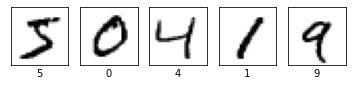

Размер тренировачных данных: x_train = (60000, 784), y_train = (60000, 10)
Размер тестовых данных: x_test = (10000, 784), y_test = (10000, 10)


In [2]:
# Размер изображений в базе MNIST составляет 28x28
w, h = 28, 28
# Для задачи классификации рукописных цир мы имеем 10 классов изображений
count_of_classes = 10

# Загрузка данных MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Визуализация

# Выведем на экран 5 примеров из набора тренировачных данных
for i in range(5) :
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

# Предобработка данных:
# Значение каждого пикселя в изображении находится в интервале [0,255]. 
# Для правильной работы модели, они должны быть в интервале [0, 1].
# Следовательно, их надо нормализовать

x_train = x_train.reshape(x_train.shape[0], w * h)
x_test = x_test.reshape(x_test.shape[0], w * h)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

y_train = np.eye(count_of_classes)[y_train]
y_test = np.eye(count_of_classes)[y_test]

print('Размер тренировачных данных: x_train = {}, y_train = {}'.format(x_train.shape, y_train.shape))
print('Размер тестовых данных: x_test = {}, y_test = {}'.format(x_test.shape, y_test.shape))

## 2) Реализация модели

In [3]:
class NeuralNetwork:
    # input_layer  - количество нейронов на входе
    # hidden_layer - количество нейронов на скрытом слое
    # output_layer - количество нейронов на выходе
    def __init__(self, input_layer, hidden_layer, output_layer):
        
        self.W1 = np.random.randn(input_layer, hidden_layer) * 0.01
        self.W2 = np.random.randn(hidden_layer, output_layer) * 0.01
        self.b1 = np.zeros((1, hidden_layer))
        self.b2 = np.zeros((1, output_layer))

    # Вспомогательные функции
    #                 
    # Функция активации на скрытом слое
    def ReLU(self, x):
        return np.maximum(0, x)

    # Функция активации на выходном слое
    def softmax(self, x):
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis = 1, keepdims = True)

    # Функция ошибки
    def crossEntropyLoss(self, y, u):
        return np.mean(-np.sum(y * np.log(u), axis = 1))

    # Функция точности
    def get_accuracy(self, x, y):
        return np.mean(np.argmax(x, axis = 1) == np.argmax(y, axis = 1))

    # Прямой проход
    def forward(self, x):
        self.v1 = np.dot(x, self.W1) + self.b1
        self.val_ReLU = self.ReLU(self.v1)
        self.v2 = np.dot(self.val_ReLU, self.W2) + self.b2
        self.val_softmax = self.softmax(self.v2)
        return self.val_softmax
    
    # Обратный проход
    def backward(self, x, y, learning_rate):
        dv2 = (self.val_softmax - y) / self.val_softmax.shape[0]
        dW2 = (self.val_ReLU.T).dot(dv2)
        db2 = np.sum(dv2, axis = 0, keepdims = True)
        dReLU = np.where(self.v1 > 0, 1, 0)
        dv1 = dv2.dot(self.W2.T) * dReLU
        dW1 = np.dot(x.T, dv1)
        db1 = np.sum(dv1, axis = 0, keepdims = True)

        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
    
    # Обучение
    # batch_size - размер пачки
    # learning_rate - скорость обучения
    def train(self, x, y, epochs, batch_size, learning_rate):
        start = time.time()
        for epoch in range(epochs):
            start_epoch = time.time()
            for i in range(0, len(x), batch_size):
                x_curr = x[i : i + batch_size]
                y_curr = y[i : i + batch_size]
                self.forward(x_curr)
                self.backward(x_curr, y_curr, learning_rate)
        
            self.forward(x)
            print('Эпоха № {}; Ошибка = {:.4f}; Точность = {:.4f}; Время = {:.4f}'
                .format(epoch, self.crossEntropyLoss(y, self.val_softmax), 
                self.get_accuracy(y, self.val_softmax), time.time() - start_epoch))
        general_train_time = time.time() - start
        print(f"Общее время обучение: {general_train_time:.4f}")
    
    # Тестирование
    def test(self, x, y):
        start = time.time()
        self.forward(x)
        print('Точность на тестовой выборке {:.4f}; Ошибка = {:.4f}; Время = {:.4f}'
                .format(self.get_accuracy(y, self.val_softmax), self.crossEntropyLoss(y, self.val_softmax), 
                 time.time() - start))

## 3) Работа с данными из примера

Вводим параметры работы модели

In [4]:
batch_size = 64
num_epochs = 10 
hidden_neurons = 200
learning_rate = 0.1

Инициализируем и тренируем модель 

In [5]:
nnetwork = NeuralNetwork(w * h, hidden_neurons, count_of_classes)
nnetwork.train(x_train, y_train, num_epochs, batch_size, learning_rate)

Эпоха № 0; Ошибка = 0.2889; Точность = 0.9135; Время = 2.3471
Эпоха № 1; Ошибка = 0.2062; Точность = 0.9395; Время = 2.3391
Эпоха № 2; Ошибка = 0.1582; Точность = 0.9535; Время = 2.2390
Эпоха № 3; Ошибка = 0.1276; Точность = 0.9625; Время = 2.3822
Эпоха № 4; Ошибка = 0.1069; Точность = 0.9690; Время = 2.2811
Эпоха № 5; Ошибка = 0.0919; Точность = 0.9738; Время = 2.2490
Эпоха № 6; Ошибка = 0.0802; Точность = 0.9773; Время = 2.2601
Эпоха № 7; Ошибка = 0.0707; Точность = 0.9802; Время = 2.2350
Эпоха № 8; Ошибка = 0.0635; Точность = 0.9821; Время = 2.2160
Эпоха № 9; Ошибка = 0.0572; Точность = 0.9840; Время = 2.2120
Общее время обучение: 22.7607


Тестируем можель

In [6]:
nnetwork.test(x_test, y_test)

Точность на тестовой выборке 0.9750; Ошибка = 0.0819; Время = 0.0921


## 4) Контрольный набор параметров

Контрольный набор параметров: размер пачки может меняться от 8 до 64 изображений (в зависимости от доступного объема памяти), скорость обучения составляет 0.1, количество скрытых нейронов – 300, количество эпох – 20.

In [15]:
batch_size = 16
learning_rate = 0.1
hidden_neurons = 300
num_epochs = 20


Инициализируем и тренируем модель 

In [16]:
nnetwork = NeuralNetwork(w * h, hidden_neurons, count_of_classes)
nnetwork.train(x_train, y_train, num_epochs, batch_size, learning_rate)

Эпоха № 0; Ошибка = 0.1488; Точность = 0.9537; Время = 9.0838
Эпоха № 1; Ошибка = 0.0923; Точность = 0.9716; Время = 9.4786
Эпоха № 2; Ошибка = 0.0708; Точность = 0.9780; Время = 8.7199
Эпоха № 3; Ошибка = 0.0569; Точность = 0.9819; Время = 8.4717
Эпоха № 4; Ошибка = 0.0453; Точность = 0.9853; Время = 8.5998
Эпоха № 5; Ошибка = 0.0376; Точность = 0.9880; Время = 8.5578
Эпоха № 6; Ошибка = 0.0306; Точность = 0.9902; Время = 8.7379
Эпоха № 7; Ошибка = 0.0249; Точность = 0.9921; Время = 8.5491
Эпоха № 8; Ошибка = 0.0213; Точность = 0.9934; Время = 8.0932
Эпоха № 9; Ошибка = 0.0175; Точность = 0.9949; Время = 9.1793
Эпоха № 10; Ошибка = 0.0155; Точность = 0.9956; Время = 8.8110
Эпоха № 11; Ошибка = 0.0139; Точность = 0.9960; Время = 9.2194
Эпоха № 12; Ошибка = 0.0117; Точность = 0.9970; Время = 9.1243
Эпоха № 13; Ошибка = 0.0086; Точность = 0.9981; Время = 9.4556
Эпоха № 14; Ошибка = 0.0069; Точность = 0.9987; Время = 8.8363
Эпоха № 15; Ошибка = 0.0059; Точность = 0.9990; Время = 9.2005
Эп

Тестируем можель

In [17]:
nnetwork.test(x_test, y_test)

Точность на тестовой выборке 0.9817; Ошибка = 0.0728; Время = 0.1141


## 5) Сравнение с реализацией из библиотеки PyTorch

In [18]:
import torch
import torch.nn

In [19]:
class NNetwork(torch.nn.Module):
    def __init__(self):
        super(NNetwork, self).__init__()
        self.linear1 = torch.nn.Linear(w * h, hidden_neurons)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_neurons, count_of_classes)
        
      
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return torch.nn.functional.log_softmax(x, dim = 1)


nnetwork = NNetwork()
print(nnetwork)

NNetwork(
  (linear1): Linear(in_features=784, out_features=300, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=300, out_features=10, bias=True)
)


In [20]:
# Функция подсчета ошибки
def get_accuracy(x, y):
        return np.mean(np.argmax(x, axis = 1) == np.argmax(y, axis = 1))

In [21]:
# Обучение построенной модели на CPU

# Выбор устройства для вычислений
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nnetwork.to(device)

# Функция ошибки на этапе обучения
loss_function = torch.nn.CrossEntropyLoss()

# Метод оптимизации для обучения параметров
optimizer = torch.optim.SGD(nnetwork.parameters(), lr = learning_rate)

start = time.time()
for epoch in range(num_epochs):
    start_epoch = time.time()
    for i in range(0, len(x_train), batch_size):
        x_curr = torch.tensor(x_train[i : i + batch_size])
        y_curr = torch.tensor(y_train[i : i + batch_size]) 
        
        # Прямой проход
        outputs = nnetwork(x_curr) # вычисление выхода сети
        loss = loss_function(outputs, y_curr) # вычисление функции ошибки
        
        # Обратный проход
        optimizer.zero_grad() # обнуление всех вычисляемых градиентов
        loss.backward() # вычисление градиента функции ошибки
        optimizer.step() # обновление параметров модели
        
    print('Эпоха № {}; Ошибка = {:.4f}; Точность = {:.4f}; Время = {:.4f}'
                .format(epoch, loss.item(), 
                get_accuracy(nnetwork(torch.tensor(x_train)).detach().numpy(), y_train),
                time.time() - start_epoch))


general_train_time = time.time() - start
print(f"Общее время обучение: {general_train_time:.4f}")

Эпоха № 0; Ошибка = 0.0134; Точность = 0.9577; Время = 3.5272
Эпоха № 1; Ошибка = 0.0039; Точность = 0.9737; Время = 3.4962
Эпоха № 2; Ошибка = 0.0026; Точность = 0.9803; Время = 3.5282
Эпоха № 3; Ошибка = 0.0019; Точность = 0.9841; Время = 3.3981
Эпоха № 4; Ошибка = 0.0015; Точность = 0.9877; Время = 3.3540
Эпоха № 5; Ошибка = 0.0017; Точность = 0.9901; Время = 3.3691
Эпоха № 6; Ошибка = 0.0022; Точность = 0.9920; Время = 3.3410
Эпоха № 7; Ошибка = 0.0027; Точность = 0.9933; Время = 3.3440
Эпоха № 8; Ошибка = 0.0018; Точность = 0.9940; Время = 3.3761
Эпоха № 9; Ошибка = 0.0018; Точность = 0.9948; Время = 3.3681
Эпоха № 10; Ошибка = 0.0014; Точность = 0.9957; Время = 3.3420
Эпоха № 11; Ошибка = 0.0017; Точность = 0.9958; Время = 3.3971
Эпоха № 12; Ошибка = 0.0010; Точность = 0.9965; Время = 3.4021
Эпоха № 13; Ошибка = 0.0007; Точность = 0.9975; Время = 3.3901
Эпоха № 14; Ошибка = 0.0003; Точность = 0.9987; Время = 3.3621
Эпоха № 15; Ошибка = 0.0002; Точность = 0.9991; Время = 3.3651
Эп

In [22]:
print('Точность на тестовой выборке {:.4f}'
                .format(get_accuracy(nnetwork(torch.tensor(x_test)).detach().numpy(), y_test)))
        

Точность на тестовой выборке 0.9819


Для контрольных значений параметров нами была достигнута точность классификации на тестовых данных, сравнимая с точностью, которую выдают стандартные инструменты глубокого обучения (PyTorch): у нас 0.9817, а в PyTorch - 0.9819